A forecasting model is to be built based on simulated user information and past loan history, for the amount of loan a user may apply for next month

In [1]:
import pandas as pd
import numpy as np

# display all varibales
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
user = pd.read_csv('user.csv')
loan = pd.read_csv('loan.csv')
user.head()
loan.head()

,uid,age,sex,active_date,limit
0,26308,30,1,2016-02-16,15000.0
1,78209,40,1,2016-02-21,5000.0
2,51930,35,1,2016-04-19,25000.0
3,10113,25,1,2016-03-12,25000.0
4,17067,35,1,2016-02-16,15000.0


,uid,loan_time,loan_amount,plannum
0,12135,2016-08-03 00:05:26,500.0,1
1,41403,2016-08-03 00:13:25,8000.0,3
2,74458,2016-08-03 00:13:58,2000.0,1
3,12959,2016-08-03 00:19:33,500.0,1
4,89641,2016-08-03 00:23:13,1000.0,1


In [3]:
user['active_month'] = user.active_date.apply(lambda x: x[0:7].replace('-', '')).astype(int)
user['active_date'] = pd.to_datetime(user.active_date)
loan['date'] = pd.to_datetime(loan.loan_time.apply(lambda x: x[0:10]))
loan['month'] = loan.loan_time.apply(lambda x: x[0:7].replace('-', '')).astype(int)

In [4]:
plannum_train_max = loan[loan.month < 201610].groupby(['uid']).agg({'plannum':['max', 'mean']}).reset_index()
plannum_train_max.columns = ['uid', 'plannum_max', 'plannum_mean']

plannum_test_max = loan[loan.month < 201611].groupby(['uid']).agg({'plannum':['max', 'mean']}).reset_index()
plannum_test_max.columns = ['uid', 'plannum_max', 'plannum_mean']

In [5]:
loan['end_month'] = loan.month + loan.plannum
loan['payment_month'] = loan.loan_amount / loan.plannum


# 预测当月需要还多少
loan_train = loan[loan.month < 201610]
loan_train.head()
loan_train_2 = loan_train[(201610 <= loan.end_month)].groupby(['uid']).agg({'payment_month':['sum']}).reset_index()
loan_train_2.columns = ['uid','payment']
loan_train_2.head()

#剩下需要还多少
loan_will_pay = loan_train[(loan_train.end_month >= 201610 )]
loan_will_pay['will_pay'] =  (loan_will_pay.end_month - 201609) * loan_will_pay.payment_month
loan_will_pay_2 = loan_will_pay.groupby(['uid']).agg({'will_pay':['sum']}).reset_index()
loan_will_pay_2.columns = ['uid','remain_payment']

loan_will_pay_2.head()

loan_test = loan[(201611 <= loan.end_month) & (loan.month != 201611)].groupby(['uid']).agg({'payment_month':['sum']}).reset_index()
loan_test.columns = ['uid','payment']
loan_test.head()

loan_test_2 = loan[(loan.month == 201610) | (loan.month == 201609)]

loan_will_pay_test = loan_test_2[(loan_test_2.end_month >= 201611 )]
loan_will_pay_test['will_pay'] =  (loan_will_pay_test.end_month - 201610) * loan_will_pay_test.payment_month
loan_will_pay_test_2 = loan_will_pay_test.groupby(['uid']).agg({'will_pay':['sum']}).reset_index()
loan_will_pay_test_2.columns = ['uid','remain_payment']

loan_will_pay_test_2.head()


,uid,loan_time,loan_amount,plannum,date,month,end_month,payment_month
0,12135,2016-08-03 00:05:26,500.0,1,2016-08-03,201608,201609,500.000000
1,41403,2016-08-03 00:13:25,8000.0,3,2016-08-03,201608,201611,2666.666667
2,74458,2016-08-03 00:13:58,2000.0,1,2016-08-03,201608,201609,2000.000000
3,12959,2016-08-03 00:19:33,500.0,1,2016-08-03,201608,201609,500.000000
4,89641,2016-08-03 00:23:13,1000.0,1,2016-08-03,201608,201609,1000.000000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,uid,payment
0,6,8000.000000
1,19,1333.333333
2,20,21416.666667
3,23,1000.000000
4,27,833.333333


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,uid,remain_payment
0,6,24000.0
1,19,3000.0
2,20,43500.0
3,23,1000.0
4,27,5000.0


,uid,payment
0,4,5000.000000
1,6,8000.000000
2,19,833.333333
3,20,4416.666667
4,23,4500.000000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,uid,remain_payment
0,4,16000.000000
1,6,16000.000000
2,19,1666.666667
3,20,22083.333333
4,23,4500.000000


In [6]:
loan_stat_by_month = loan.groupby(['uid','month']).agg({'loan_amount':['sum','count','median'],'payment_month': ['sum']}).reset_index()

In [7]:
loan_stat_by_month.columns = ['uid','month','loan_sum','loan_count','loan_median','payment_month']

loan_stat_by_month.head()

,uid,month,loan_sum,loan_count,loan_median,payment_month
0,4,201608,9000.0,2,4500.0,9000.000000
1,4,201610,16000.0,2,8000.0,5000.000000
2,4,201611,2000.0,1,2000.0,666.666667
3,5,201611,40000.0,1,40000.0,3333.333333
4,6,201609,24000.0,1,24000.0,8000.000000


In [8]:
user_loan = loan[loan.month < 201610]
user_loan_date = user_loan.groupby(['uid']).agg({'loan_time':['max']}).reset_index();
user_loan_date.columns = ['uid','loan_time']
user_loan_max_amount = user_loan_date.merge(user_loan[['uid','loan_time','loan_amount','plannum']], on=['uid','loan_time'],how='left')
user_loan_max_amount.head()


user_loan_test = loan[loan.month < 201611]
user_loan_test_date = user_loan_test.groupby(['uid']).agg({'loan_time':['max']}).reset_index();
user_loan_test_date.columns = ['uid','loan_time']
user_loan_test_max_amount = user_loan_test_date.merge(user_loan_test[['uid','loan_time','loan_amount','plannum']], on=['uid','loan_time'],how='left')
user_loan_test_max_amount.head()


,uid,loan_time,loan_amount,plannum
0,4,2016-08-12 21:51:25,4000.0,1
1,6,2016-09-11 12:14:52,24000.0,3
2,19,2016-09-21 15:50:54,500.0,1
3,20,2016-09-28 08:40:04,3500.0,1
4,23,2016-09-13 19:10:54,500.0,1


,uid,loan_time,loan_amount,plannum
0,4,2016-10-29 17:52:58,12000.0,12
1,6,2016-09-11 12:14:52,24000.0,3
2,19,2016-09-21 15:50:54,500.0,1
3,20,2016-09-28 08:40:04,3500.0,1
4,23,2016-10-24 18:42:21,500.0,1


In [9]:
train_past = loan[loan.month < 201610]
train_past = train_past.groupby(['uid','month']).agg({'loan_amount':['mean','sum']}).reset_index()
train_past.columns = ['uid','month','past_loan_mean','past_loan_sum']
train_past.head()

test_past = loan[loan.month < 201611]
test_past = test_past.groupby(['uid','month']).agg({'loan_amount':['mean','sum']}).reset_index()
test_past.columns = ['uid','month','past_loan_mean','past_loan_sum']
test_past.head()

,uid,month,past_loan_mean,past_loan_sum
0,4,201608,4500.0,9000.0
1,6,201609,24000.0,24000.0
2,19,201609,1500.0,3000.0
3,20,201608,5100.0,30600.0
4,20,201609,14500.0,43500.0


,uid,month,past_loan_mean,past_loan_sum
0,4,201608,4500.0,9000.0
1,4,201610,8000.0,16000.0
2,6,201609,24000.0,24000.0
3,19,201609,1500.0,3000.0
4,20,201608,5100.0,30600.0


In [10]:
train = user.merge(loan_stat_by_month[loan_stat_by_month.month == 201610][['uid','loan_sum']],on='uid',how='left')
train = train.rename(columns = {'loan_sum':'target'})

train.target = train.target.fillna(0)
train = train.merge(loan_stat_by_month[loan_stat_by_month.month == 201609][['uid','loan_sum','loan_count','loan_median','payment_month']],on='uid',how='left')
train = train.rename(columns = {'loan_sum':'pre_1_loan_sum',
                                'loan_count':'pre_1_loan_count',
                                'loan_median':'pre_1_loan_median',
                                'payment_month':'pre_1_payment_month',
                                'loan_payment':'pre_1_payment'})
train = train.fillna(0)
train = train.merge(loan_stat_by_month[loan_stat_by_month.month == 201608][['uid','loan_sum','loan_count','loan_median','payment_month']],on='uid',how='left')
train = train.rename(columns = {'loan_sum':'pre_2_loan_sum',
                                'loan_count':'pre_2_loan_count',
                                'loan_median':'pre_2_loan_median',
                                'payment_month':'pre_2_payment_month',
                                'loan_payment':'pre_2_payment'})

train = train.merge(loan_train_2,on='uid',how='left')
train = train.merge(loan_will_pay_2,on='uid',how='left')
train = train.merge(user_loan_max_amount,on='uid',how='left')
train = train.merge(plannum_train_max,on='uid',how='left')
# train = train.merge(train_past[['uid','past_loan_mean','past_loan_sum']],on='uid',how='left')
                    
train = train.fillna(0)
train['active_dif'] = (pd.to_datetime('2016-10-01') - train.active_date ).dt.days
train = train.drop(['active_date'], axis = 1)
train.head()

,uid,age,sex,limit,active_month,target,pre_1_loan_sum,pre_1_loan_count,pre_1_loan_median,pre_1_payment_month,...,pre_2_loan_median,pre_2_payment_month,payment,remain_payment,loan_time,loan_amount,plannum,plannum_max,plannum_mean,active_dif
0,26308,30,1,15000.0,201602,16500.0,3500.0,2.0,1750.0,3500.0,...,1250.0,2500.0,3500.0,3500.0,2016-09-23 08:11:19,2000.0,1.0,1.0,1.0,228
1,78209,40,1,5000.0,201602,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,223
2,51930,35,1,25000.0,201604,0.0,30000.0,1.0,30000.0,5000.0,...,0.0,0.0,5000.0,30000.0,2016-09-07 15:06:37,30000.0,6.0,6.0,6.0,165
3,10113,25,1,25000.0,201603,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,203
4,17067,35,1,15000.0,201602,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,228


In [11]:
test = user.merge(loan_stat_by_month[loan_stat_by_month.month == 201611][['uid','loan_sum']],on='uid',how='left')
test = test.rename(columns = {'loan_sum':'target'})
test.target = test.target.fillna(0)
test = test.merge(loan_stat_by_month[loan_stat_by_month.month == 201610][['uid','loan_sum','loan_count','loan_median','payment_month']],on='uid',how='left')
test = test.rename(columns = {'loan_sum':'pre_1_loan_sum',
                              'loan_count':'pre_1_loan_count',
                              'loan_median':'pre_1_loan_median',
                              'payment_month':'pre_1_payment_month',
                              'loan_payment':'pre_1_payment'})
test = test.fillna(0)
test = test.merge(loan_stat_by_month[loan_stat_by_month.month == 201609][['uid','loan_sum','loan_count','loan_median','payment_month']],on='uid',how='left')
test = test.rename(columns = {'loan_sum':'pre_2_loan_sum',
                              'loan_count':'pre_2_loan_count',
                              'loan_median':'pre_2_loan_median',
                              'payment_month':'pre_2_payment_month',
                              'loan_payment':'pre_2_payment'})

test = test.merge(loan_test,on='uid',how='left')
test = test.merge(loan_will_pay_test_2,on='uid',how='left')
test = test.merge(user_loan_test_max_amount,on='uid',how='left')
test = test.merge(plannum_test_max,on='uid',how='left')
# test = test.merge(test_past[['uid','past_loan_mean','past_loan_sum']],on='uid',how='left')
test = test.fillna(0)
test['active_dif'] = (pd.to_datetime('2016-11-01') - test.active_date ).dt.days
test = test.drop(['active_date'], axis = 1)
test.head()

,uid,age,sex,limit,active_month,target,pre_1_loan_sum,pre_1_loan_count,pre_1_loan_median,pre_1_payment_month,...,pre_2_loan_median,pre_2_payment_month,payment,remain_payment,loan_time,loan_amount,plannum,plannum_max,plannum_mean,active_dif
0,26308,30,1,15000.0,201602,7000.0,16500.0,8.0,1000.0,14833.333333,...,1750.0,3500.0,14833.333333,16500.0,2016-10-31 15:38:07,1000.0,1.0,3.0,1.333333,259
1,78209,40,1,5000.0,201602,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,254
2,51930,35,1,25000.0,201604,0.0,0.0,0.0,0.0,0.000000,...,30000.0,5000.0,5000.000000,25000.0,2016-09-07 15:06:37,30000.0,6.0,6.0,6.000000,196
3,10113,25,1,25000.0,201603,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,234
4,17067,35,1,15000.0,201602,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,259


In [12]:
columns = ['age', 'sex', 'limit', 'pre_1_loan_sum', 'pre_1_loan_count', 'pre_2_loan_sum', 'pre_2_loan_count', 
                 'pre_1_loan_median', 'pre_2_loan_median', 'payment','remain_payment','loan_amount','plannum']
Y_train = train.target
# X_train = train.drop(['target','uid','pre_1_payment','pre_2_payment'],axis = 1)
X_train = train[columns]
X_train['age_limit'] = train.age * train.limit
X_train.head()
Y_train.head()

Y_test = test.target
# X_test = test.drop(['target','uid','pre_1_payment','pre_2_payment'],axis = 1)
X_test = test[columns]
X_test['age_limit'] = test.age * test.limit
X_test.head()
Y_test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,sex,limit,pre_1_loan_sum,pre_1_loan_count,pre_2_loan_sum,pre_2_loan_count,pre_1_loan_median,pre_2_loan_median,payment,remain_payment,loan_amount,plannum,age_limit
0,30,1,15000.0,3500.0,2.0,2500.0,2.0,1750.0,1250.0,3500.0,3500.0,2000.0,1.0,450000.0
1,40,1,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200000.0
2,35,1,25000.0,30000.0,1.0,0.0,0.0,30000.0,0.0,5000.0,30000.0,30000.0,6.0,875000.0
3,25,1,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,625000.0
4,35,1,15000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,525000.0


0    16500.0
1        0.0
2        0.0
3        0.0
4        0.0
Name: target, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,age,sex,limit,pre_1_loan_sum,pre_1_loan_count,pre_2_loan_sum,pre_2_loan_count,pre_1_loan_median,pre_2_loan_median,payment,remain_payment,loan_amount,plannum,age_limit
0,30,1,15000.0,16500.0,8.0,3500.0,2.0,1000.0,1750.0,14833.333333,16500.0,1000.0,1.0,450000.0
1,40,1,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,200000.0
2,35,1,25000.0,0.0,0.0,30000.0,1.0,0.0,30000.0,5000.000000,25000.0,30000.0,6.0,875000.0
3,25,1,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,625000.0
4,35,1,15000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,525000.0


0    7000.0
1       0.0
2       0.0
3       0.0
4       0.0
Name: target, dtype: float64

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 2, 'random_state': 1}

random_forest = RandomForestRegressor(**params)
random_forest.fit(X_train, Y_train)
y_predict = random_forest.predict(X_test)

np.sqrt(mean_squared_error(Y_test, y_predict))
result = pd.DataFrame()
result['uid'] = test.uid
result['loan_sum'] = y_predict
result.to_csv('Tmac Zhou.csv', index=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

7663.9530544312156

<Container object of 14 artists>

([<matplotlib.axis.YTick at 0x151a3f60>,
 <a list of 14 Text yticklabel objects>)

Text(0.5,0,'Relative Importance')

Text(0.5,1,'Variable Importance')

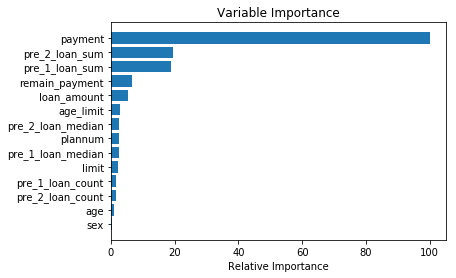

In [14]:
import matplotlib.pyplot as plt
feature_importance = random_forest.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])

plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()